<font size="4">Основные задачи:</font>
- провести анализ и подготовить план действий по удержанию клиентов
- научиться прогнозировать вероятность оттнока ( на уровне следующего месяца) для каждого клиента
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основыне свойства
- проанализировать основные признаки, наиболее сильно влияющие на отток 
- сформулировать основные выводы и рекомендации по повышению  качества работы с клиентами:
     * 1) выделить целевые группы клиентов
     * 2) предложить меры по снижению оттока
     * 3) определить другие особенности взаимодействия с клиентами 

## Загрузка данных

In [1]:
!pip install pandas-profiling[notebook]

In [2]:
!pip install matplotlib==3.4.3 --user

In [3]:
import pandas as pd
import numpy as np
import math 
import datetime as dt
import seaborn as sns
import random
from datetime import datetime, timedelta
pd.set_option('display.max_columns', 40)
import warnings
warnings.filterwarnings('ignore')

In [4]:
from pandas_profiling import ProfileReport

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [7]:
# путь к csv файлу на локальной машине
path = 'gym_churn.csv'

In [8]:
# подключение csv файла
try:
    gym_raw_data = pd.read_csv(path)
except:
    gym_raw_data =  pd.read_csv('/datasets/gym_churn.csv')

In [9]:
gym_raw_data.head()

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0

In [10]:
gym_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Информация о признаках и целевой переменной:

Признаки:

- Данные клиента за предыдущий до проверки факта оттока месяц:
    * `gender` - пол
    * `Near_Location` - проживание или работа в районе где находится фитнес-центр
    * `Partner` - сотрудник компании-партнера клуба 
    * `Promo_friends` - факт первоночальной записи в рамках акции "приведи друга"
    * `Phone` - наличие контактного телефона
    * `Age` - возраст
    * `Lifetime` - время с момента обращения в фитнес-центр (в месяцах)
- Информация на основе журнала посещений, покупок и информация о тукущем статусе абонемента клиента
    * `Contract_period` - длительность текущего действующего абонемента (месяц 6 месяцев в год)
    * `Month_to_end_contract` - срок до окончания текущего действующего абонемента (в месяцах)
    * `Group_visits` - факт посещения групповых занятий
    * `Avg_class_frequency_total` - средняя частота посещений в неделю за все время с начала действия абонемента
    * `Avg_class_frequency_current_month` - средняя частота посещений в неделю  за предыдущий месяц
    * `Avg_additional_charges_total` - суммарная выручка от других услуг фитнес-центра(кафе, спорттовары, косметический и массажный салон)

Целевое значение:

- `Churn` - факт оттока в текущем месяце

## Исследовательский анализ данных (DEA)

### Изучение основных признаков

In [11]:
report = ProfileReport(gym_raw_data)
report 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
# изучение среднего значения и стандартного отклонения при помощи метода describe
gym_raw_data.describe()

gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.000000    27.000000   
50%           1.000000      0.000000    29.000000   
75%           6.000000      1.000000    31.000000   
max          12.000000      1.000000    41.000000   

       Avg_additional_charges_total  Month_to_end_contract     Lifetime  \
count                   4000.000000            4000.000000  4000.000000   
mean                     146.943728               4.322750     3.724750   
std                       96.355602               4.191297     3.749267   
min                        0.148205               1.000000     0.000000   
25%                       68.868830               1.000000     1.000000   
50%                      136.220159               1.000000     3.000000   
75%                      210.949625               6.000000     5.000000   
max                      552.590740              12.000000    31.000000   

       Avg_class_frequency_total  Avg_class_frequency_current_month  \
count                4000.000000                        4000.000000   
mean                    1.879020                           1.767052   
std                     0.972245                           1.052906   
min                     0.000000                           0.000000   
25%                     1.180875                           0.963003   
50%                     1.832768                           1.719574   
75%                     2.536078                           2.510336   
max                     6.023668                           6.146783   

             Churn  
count  4000.000000  
mean      0.265250  
std       0.441521  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

### Средние занчения признаков в разбивке по целевой переменной

In [13]:
display(gym_raw_data.groupby('Churn').agg('mean'))

gender  Near_Location   Partner  Promo_friends     Phone  \
Churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       Contract_period  Group_visits        Age  Avg_additional_charges_total  \
Churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       Avg_class_frequency_current_month  
Churn                                     
0                               2.027882  
1                               1.044546

### Визуализация распределения признаков по целевой переменной

In [14]:
categorical_var = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Contract_period', 'Group_visits']

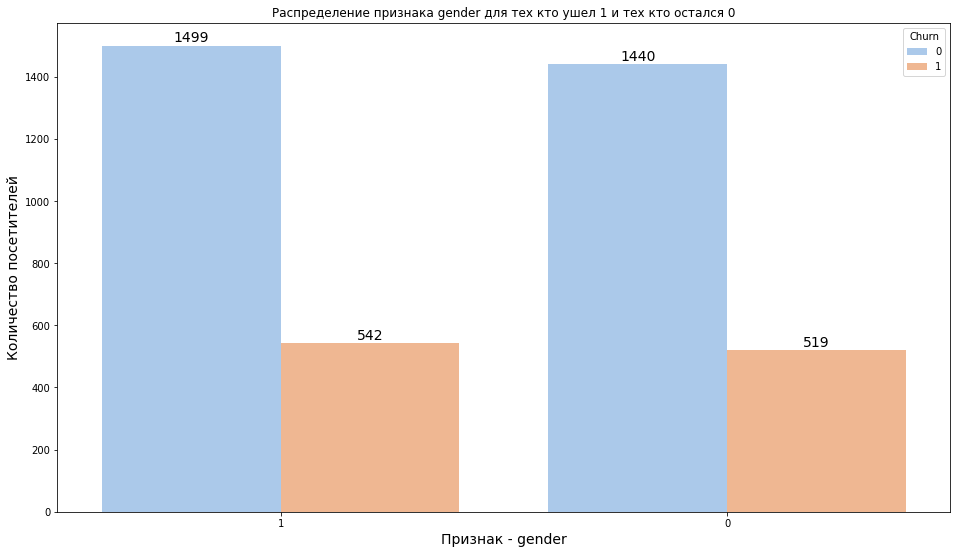

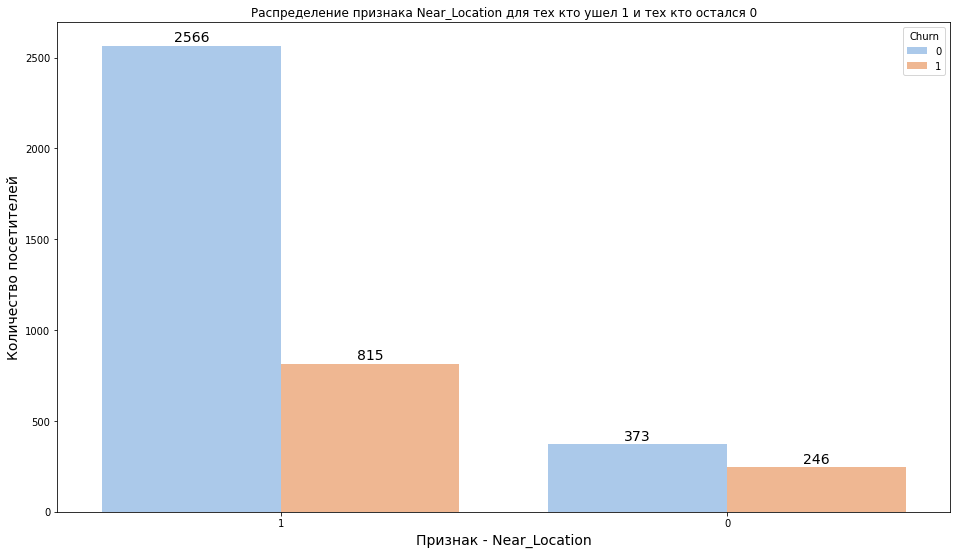

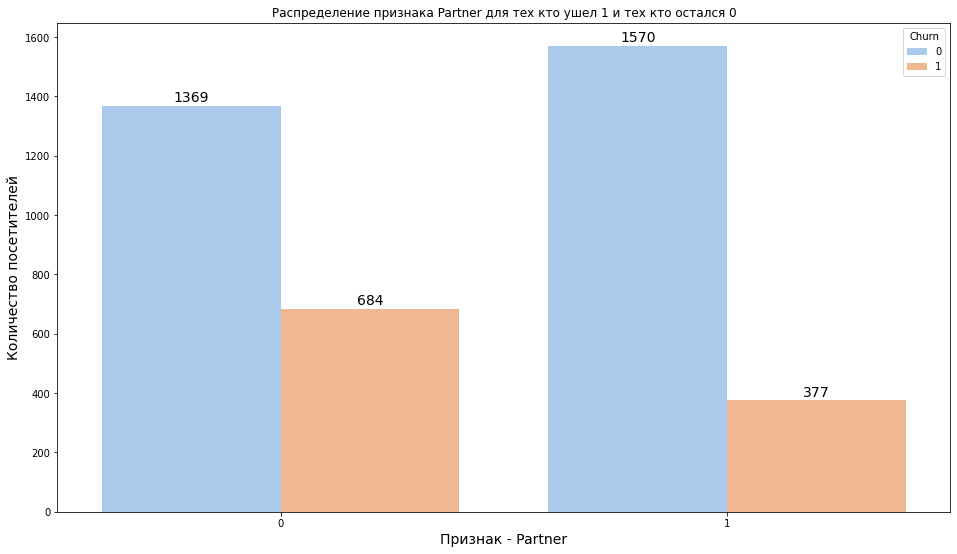

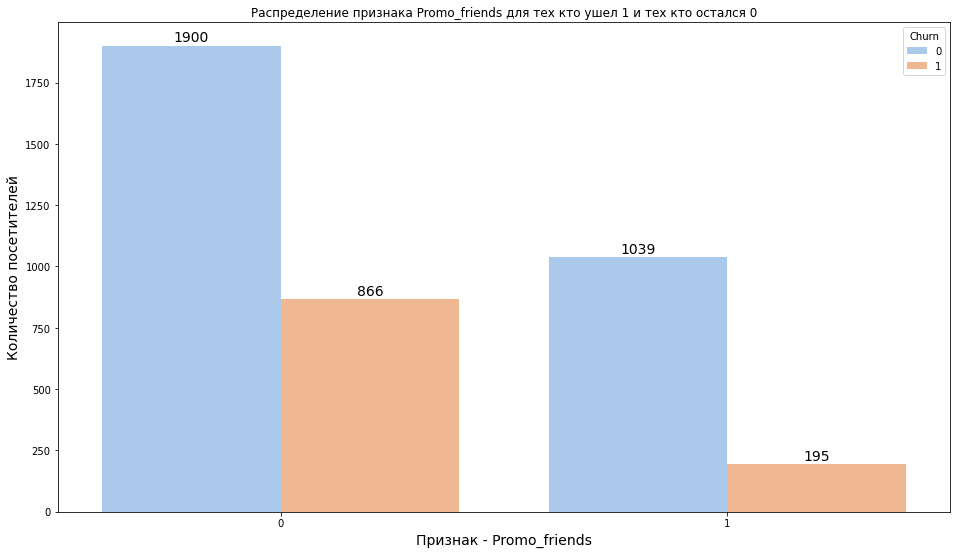

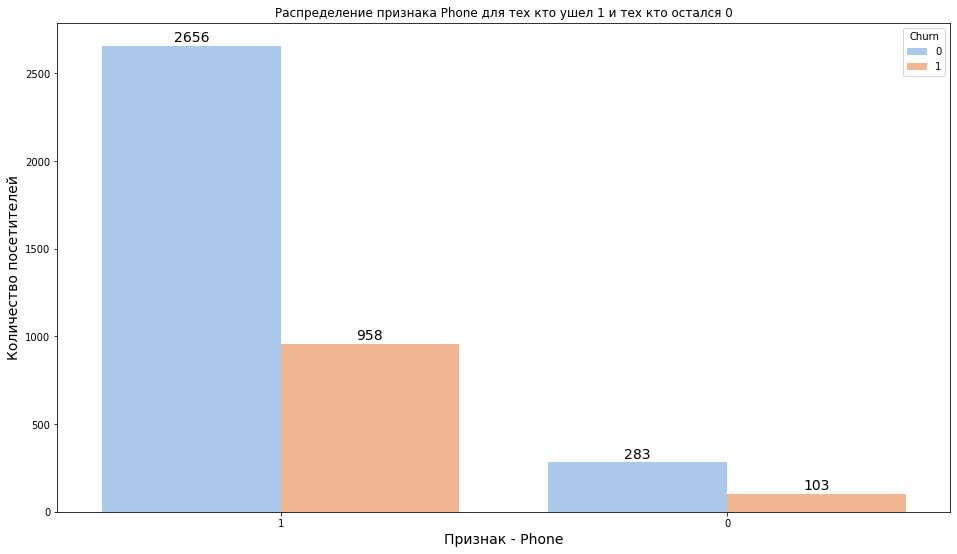

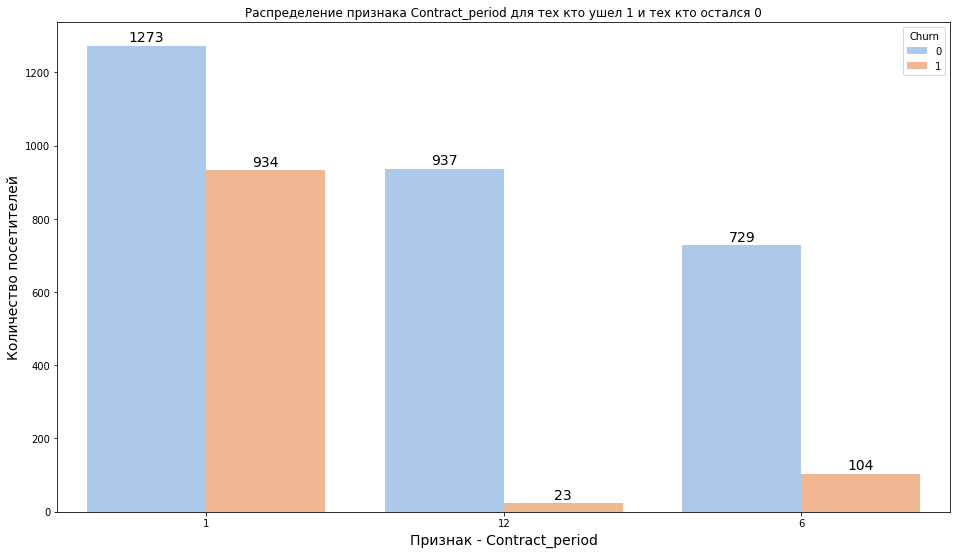

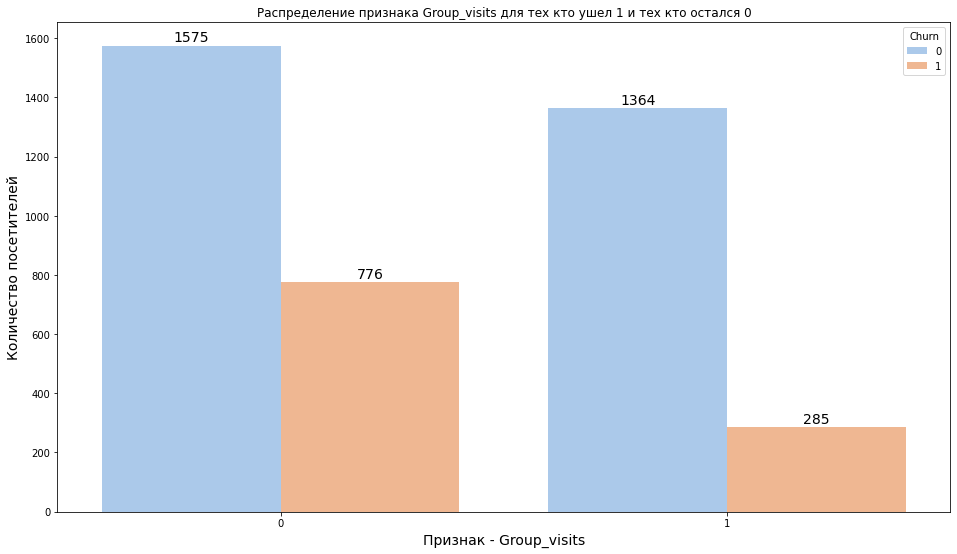

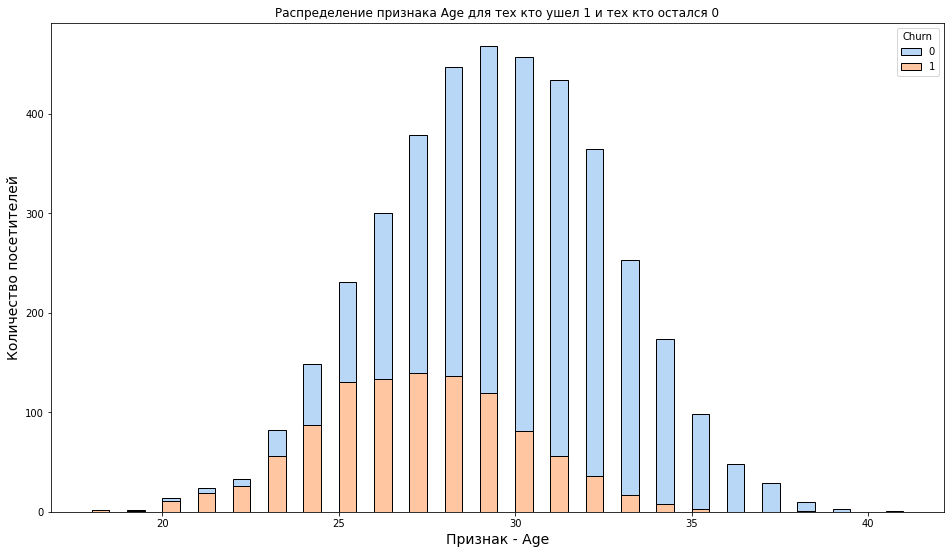

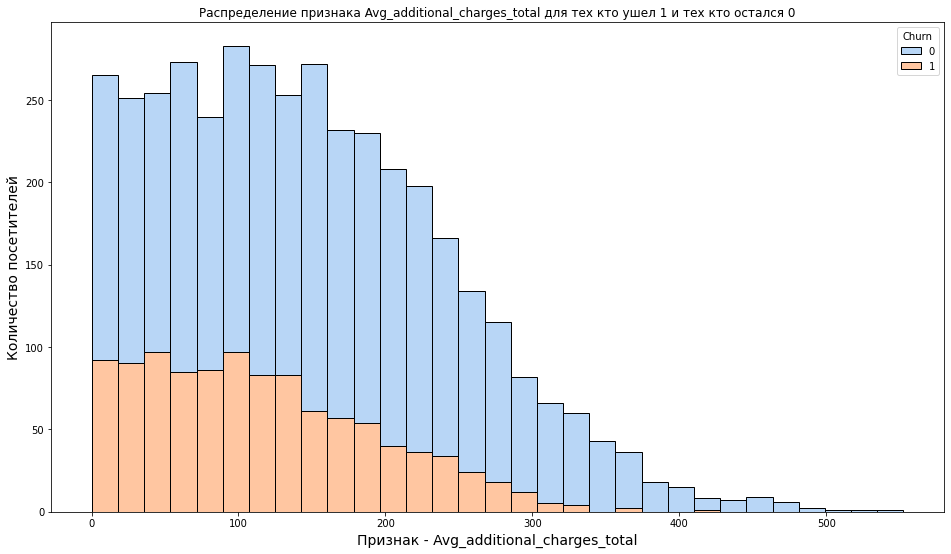

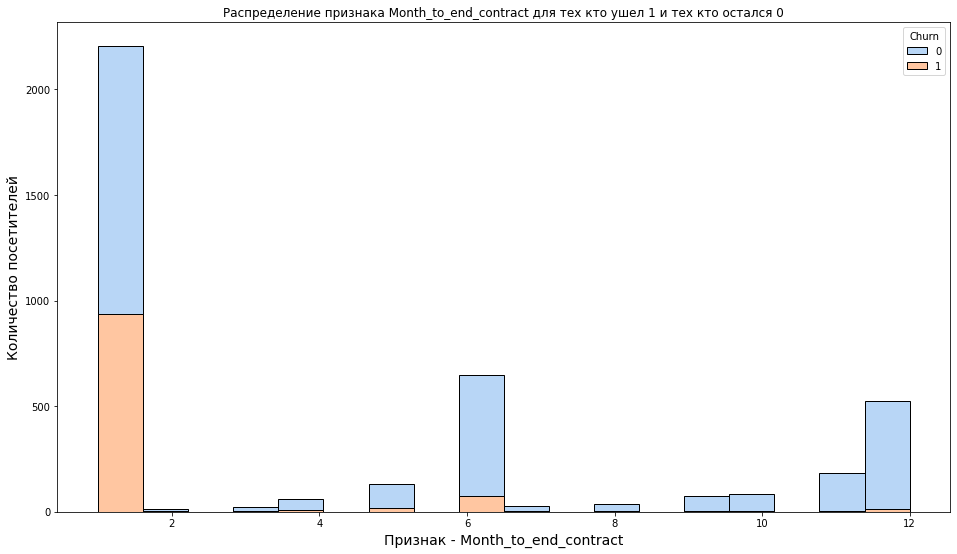

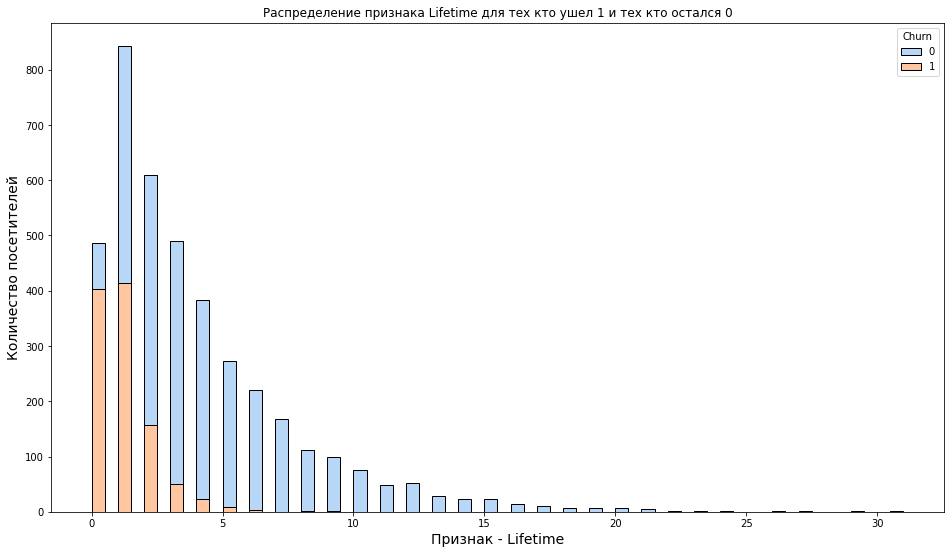

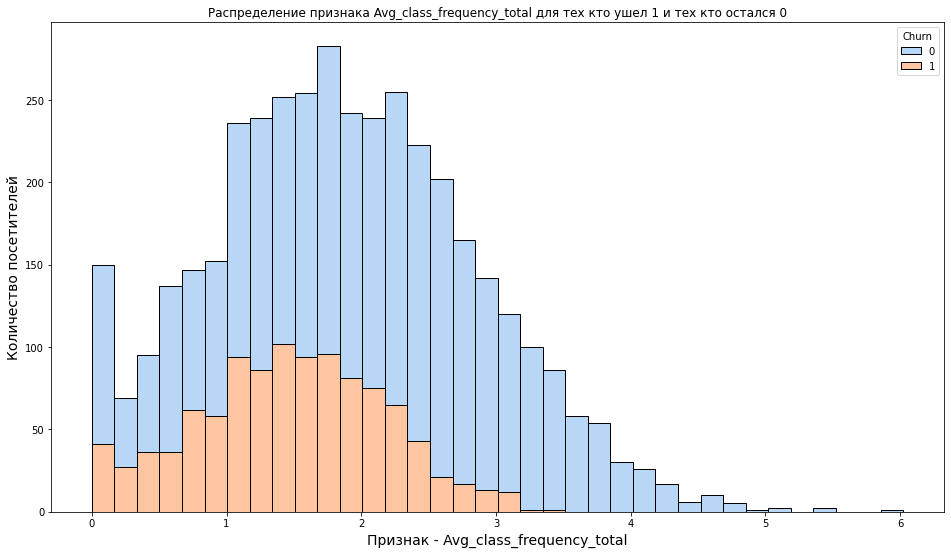

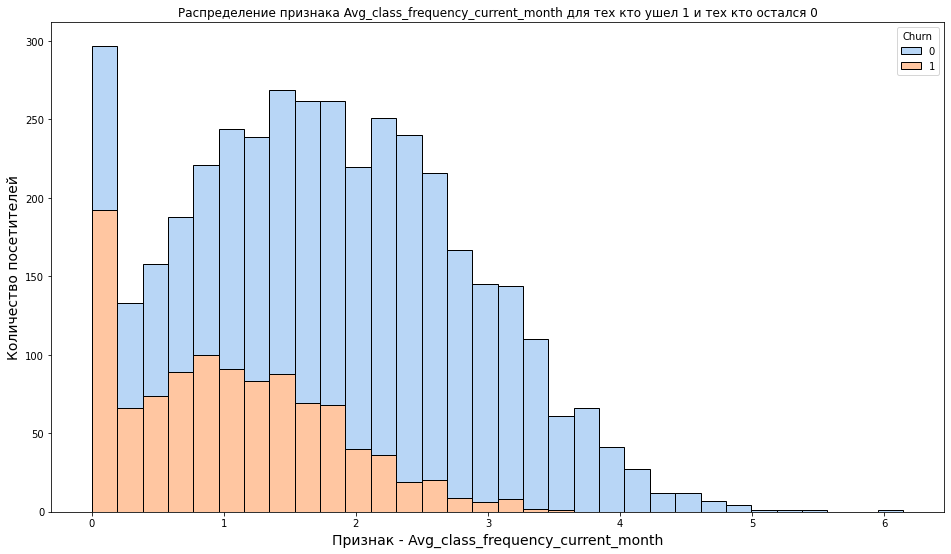

In [15]:
for i in gym_raw_data.drop('Churn', axis=1).columns:
    plt.figure(figsize=(16, 9)) 
    if i in categorical_var:
        ax = sns.countplot(data=gym_raw_data, x=i, hue='Churn', palette='pastel',
                      order=gym_raw_data[i].value_counts().index)
        for container in ax.containers:
            ax.bar_label(container, padding=1, fontsize=14)
    else:
        sns.histplot(data=gym_raw_data, x=i, hue='Churn', multiple="stack", palette='pastel')
    plt.title('Распределение признака {} для тех кто ушел 1 и тех кто остался 0'.format(i))
    plt.ylabel('Количество посетителей', fontsize=14)
    plt.xlabel('Признак - {}'.format(i), fontsize=14)
    plt.show()

###  Матрица корреляций

In [16]:
# матрица корреляции
cm = gym_raw_data.corr()

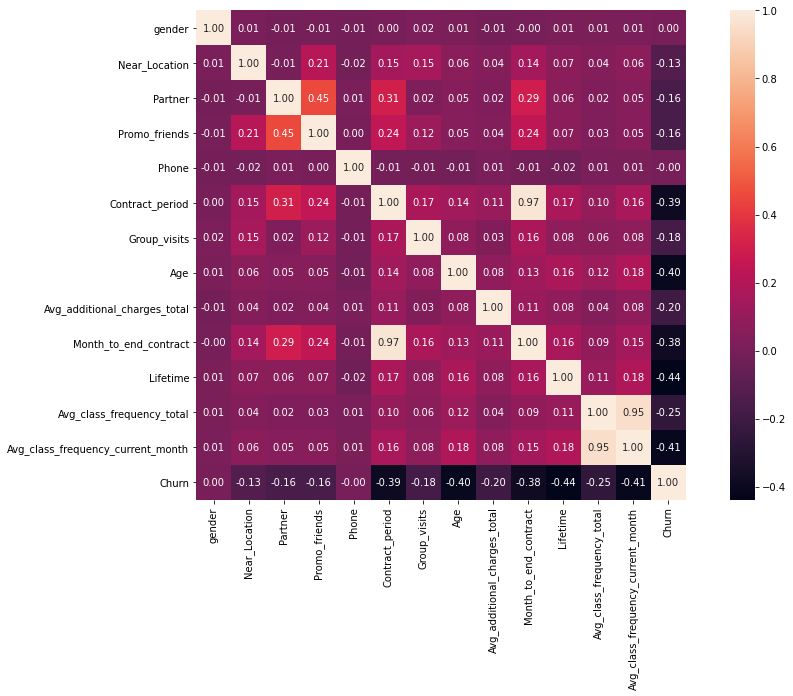

In [17]:
plt.figure(figsize=(16, 9)) 
sns.heatmap(cm, annot=True, square=True, fmt='.2f')
plt.show()

### Вывод

На основании проведенного исследовательского анализа данных можно сделать следующие выводы по признакам:
* `Gender` (пол посетителя) - В выборке присуттствует примерно равное количество людей разного пола . Пропусков среди значений этого признака не обнаружено
* `Near_Location` (клиент работает или проживает рядом с фитнес-центром) - Пропустков среди значений этого признака не обнаружено. Если судить по этому признаку то основное количество посетителей фитнес-цента работают или проживают радом с ним, таких 84.5% от общего числа. Данный признак формирует слабую отрицательную корреляцию с целевой переменной. Корреляция с остальными признаками в основном отсутствует за исключением признаков - `Promo_friends`, `Contract_period`, `Group_visits`, `Month_to_end_contract`. 
* `Parter` (посетитель сотрудник компании партнера клуба) - Пропусков среди этого параметра нет. В фитнес-цент ходит примерно половина поситителей по партнерской программе от общего числа. Среди посетители которые ходят в зал по партнерской рограмме 19% от общего чила перестали ходить, а среди людей не участвующих в этой программе таких 33%. 
* `Promo_friends` - (участие в акции приведи друга) - Всего треть от общего числа всех посетителей информация о которых представлена в датасете принимала участие в этой программе. Среди клиентов участвовавших в этой акции только 15.8% процентов перестали ходить а вот среди клиентов которые не участвовали в акции доля таких в 2 раза больше. С целевой переменной наблюдается слабая отрицательная корреляция. 
* `Phone` (информация о наличие контактного телефона) -  Только 10%  из всех клиентов не указали свой номер телефона и 26% из этого числа покинули фитнес-центр. Среди клиентов по которым есть информация о номере телефона процент людей которые покинули фитнес точно такой же - 26%. Этот признак не имеет нейтральную корреляцию с остальными признаками и целевой переменной.
* `Contract_period` (длительность текущего действующего абонемента) - Из общего числа клиентов 55% имеют длительность на ближайший месяц, 24% от общего числа имеют абонимент на 12 месяцев и 21% имеет длительность абонимента на 6 месяцев. Среди клиентов которые имеют длительность в 1 месяц 43% ушли, среди клиентов у которых еще 12 месяцев отток составил чуть более 2%, а серди клиентов с длительностью текущего абонемента 6 месяцев 12.5% перестали посещать фитнес центр.
* `Group_visits` (посещал ли клиент групповые занятия) -  Среди всех клиентов 59% не посещали групповые занятия. Среди людей не посещавщих групповые занятия 33% ушли в текущем месяце, из клиентов которые ходили такой процент составил 17%. 
* `Age` (возраст) -  Средний возраст клиентов которые покинули фитнес-центр составил 26 лет а для клиентов которые продолжили посещения 29 лет. Данный признак имеет среднюю отрицательную корреляцию с целевой переменной.
* `Avg_additional_charges_total` (суммарная выручка от дургих услуг фитнес-центра) - Данный признак имеет форму распределения с положительной скошенностью. При средних значения для людей которые перестали ходить в фитнес-центр = 115 а для людей продлодживших посещение  = 158. Данный признак имеет слабую отрицательную корреляцию к целевой переменной. 
* `Month_to_end_contract` (срок окончания текущего действующего абонемента в месяцах)- целочисленная количественная переменная без пропусков в данных. Так как здесь в основном привалирует один шесть и двенадцать месяцев то этот признак естественно имеет очень сильную положительную корреляцию с признаком `Contract_period` Можно даже сказать что эти параметры дублируют друг друга. Поэтому у данного признака похоже значение корреляции с целевой переменной и другими признаками.
* `Lifetime` (Время с момента первого посещения в месяцах) - Есть 0 значения доля которых 12% от общего числа. Возможно клиенты купили абонемент но так и не стали ходить в фитнес-центр. Или возможно это был подарок или от фирмы или от родственников. Среднее значение клиентов которые ходят равен 4 месяцам а вот у клиентов которые покидают фитнес этот показатель приближается к 1 месяцу.
* `Avg_class_frequency_total` (средняя частота посещений в неделю за все время) - количественная переменная. Количество нулевых значений в районе 2% пропусков по этому признаку нет. Среди всех клиентов распределение имеет положительную скошенность а среднее количество посещений равно 1.87. Если смотреть в разбивки по клиентам которые остались и которые ушли то среди тех кто продолжает посещение этот признак имеет среднее значение 2 а для тех кто перестал 1.47 Так же стоит заметить что если рассматривать группы людей относительно количества посещений то чем больше это значение тем меньше доля людей от общего числа перестает ходить в фитнес-центр.
* `Avg_class_frequency_current_month` (средняя частота посещений за прошлый месяц) - Количество нулевых хначений в районе 4.5% пропусков по этому признаку нет. Среди всех клиентов распределение имеет положительную скошенность а среднее количество посещений равно 1.76. Если смотреть в разбивки по целевому признаку то те кто ходят имеет среднее значение 2 а для тех кто перестал 1.04. Этот признак относительно `Avg_class_frequency_total` болле сильную отрицательную корреляцию с целевой перменно и более выраженные отношения относительно остальных признаков. 
* `Churn` - целевой признак. Только 25% от общего числа клиентов предствавленных в данных имеею положительный факт оттока. Среди всех признаков максимальную зависимость показали `Age` `Month_to_end_contract` `Contract_period` `Lifetime` `Avg_class_frequency_current_month`

## Модель  прогнозирования оттока клиентов

In [18]:
from sklearn.metrics import confusion_matrix

###  Функция для расчета метрик

In [19]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))

###  Разбиение данных на обучающую и валидационную выборку

In [20]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = gym_raw_data.drop(columns=['gender', 'Churn'])
y = gym_raw_data['Churn']

In [21]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, stratify=y)

In [22]:
# стандартизируем данные 
scaler = StandardScaler()
scaler.fit(X_train)# обучите scaler на обучающей выборке методом fit
X_train_st =scaler.transform(X_train)# стандартизируйте обучающую выборку методом transform scaler 
X_test_st = scaler.transform(X_test)# стандартизируйте тестовую выборку методом transform scaler

### Модель - алгоритм Logisstic Regression

In [23]:
lr_model = LogisticRegression(solver='liblinear', random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
# lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
threshold = 0.35
lr_predictions = [0 if i < threshold else 1 for i in lr_probabilities]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.83
	Recall: 0.89
	F1: 0.86


In [24]:
features = pd.DataFrame(data={'feature': gym_raw_data.drop(['gender', 'Churn'], axis=1).columns, 'coeff':lr_model.coef_[0]})
features.sort_values(by='coeff', ascending=False)

feature     coeff
10          Avg_class_frequency_total  3.105133
3                               Phone -0.021667
0                       Near_Location -0.052704
1                             Partner -0.068298
2                       Promo_friends -0.139555
5                        Group_visits -0.393514
7        Avg_additional_charges_total -0.561105
8               Month_to_end_contract -0.616763
4                     Contract_period -0.688226
6                                 Age -1.149072
9                            Lifetime -3.472085
11  Avg_class_frequency_current_month -4.188508

In [25]:
tn, fp, fn, tp = confusion_matrix(y_test,lr_predictions).ravel()
tn, fp, fn, tp

(549, 39, 23, 189)

### Модель - алгоритм Random Forest

In [26]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 30, random_state=0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)# Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]# Ваш код здесь
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.89
	Recall: 0.80
	F1: 0.84


In [27]:
importances_forest = pd.DataFrame({'feature': gym_raw_data.drop(['gender', 'Churn'], axis=1).columns, 'importance': rf_model.feature_importances_})
importances_forest.sort_values(by='importance', ascending=False)

feature  importance
9                            Lifetime    0.283250
11  Avg_class_frequency_current_month    0.172859
10          Avg_class_frequency_total    0.148247
6                                 Age    0.116833
7        Avg_additional_charges_total    0.088922
4                     Contract_period    0.077894
8               Month_to_end_contract    0.058956
5                        Group_visits    0.014400
1                             Partner    0.012315
0                       Near_Location    0.009818
2                       Promo_friends    0.009369
3                               Phone    0.007135

In [28]:
tn, fp, fn, tp = confusion_matrix(y_test, rf_predictions).ravel()
tn, fp, fn, tp

(567, 21, 43, 169)

### Вывод 

Были простроены две модели бинарной классификации клиентов на основе двух алгоритмов логистической регрессии и алгоритм случайного леса целевым параметром которй являлся факт отткока клиента.
После обучении модели с алгоритмом логистической регрессии произведна оценка качества модели по следующим метрика:
 * Accuracy - 0.92
 * Precision - 0.80
 * Recall - 0.87
 * F1 - 0.84

Среди признаков влияющих на значение целевой переменной можно выделить  `Avg_class_frequency_current_month`, `Avg_class_frequency_total` (эти признака являются мультиколинеарными и вследствии того что в данном алгаритме умалчанию установлено регуляризация методом Ridge можно заметить что их веса примерно одинаковы.). Далее следует признакb `Lifetime`, `Age`, `Contract_period`.

Модель обученная на основе случайного леса получила следущие значения по основным метрикам:
 * Accuracy - 0.92
 * Precision - 0.87
 * Recall - 0.82
 * F1 - 0.84

Среди признаков порядок влияния на целевую переменную следующий - `Lifetime`, `Avg_class_frequency_current_month`, `Avg_class_frequency_total` `Age`, `Avg_additional_charges_total`, `Month_to_end_contract`. (Так как у данного алгоритма так же как и логистической регресси по умолчанию для регуляризации используется Ridge можно заметить что признаки `Avg_class_frequency_current_month`, `Avg_class_frequency_total` и `Month_to_end_contract` `Contract_period` имеют между собой одинаковые веса.)

Так как основной задачей модели является нахождение клиентов которые уходят то среди всех метрик Recall имеет приоритет. 2 исследуемые модели имееют одинаковую долю правильных ответов согласно метрики  Accuracy, но алгоритм логистической регрессии имеет лучше показатели по метрики Recall относительно модели с алгоритмом случайного леса. Поэтому стоит отдать приоритет для нахождения людей попадающих в отток модели на основе линейной регрессии.

##  Кластеризация клиентов

In [29]:
# убираем столбец с целевой переменной и признака gender (по причине малой коллинеарности )
gym_data_clast = gym_raw_data.drop(columns=['gender', 'Churn'])

###  Стандартизация данных

In [30]:
# создаём объект класса scaler (нормализатор)
scaler_clast = StandardScaler()
X_sc = scaler_clast.fit_transform(gym_data_clast) # обучаем нормализатор и преобразуем набор данных

In [31]:
linked = linkage(X_sc, method = 'ward') 

### Матрица расстояний 

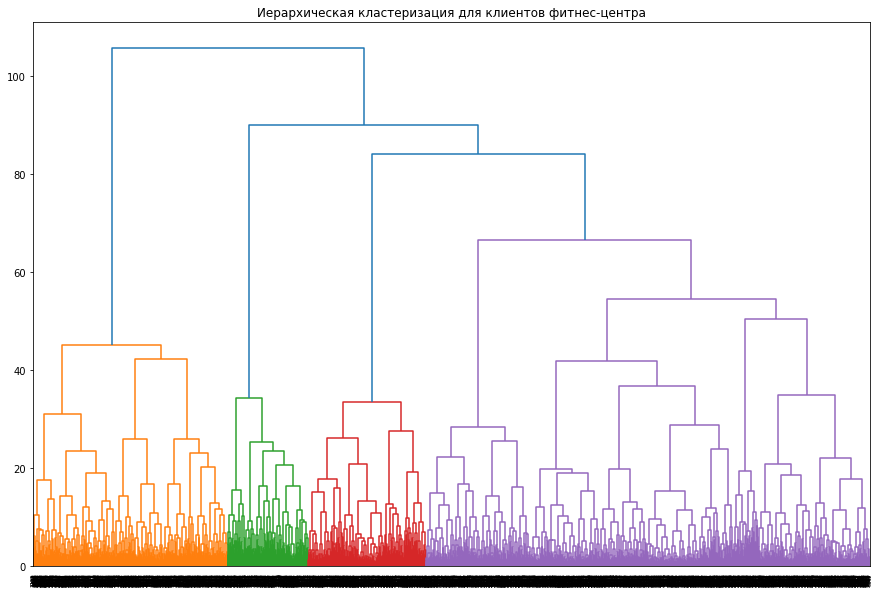

In [32]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для клиентов фитнес-центра')
plt.show()

На основании построенной матрицы расстояний считаю что оптимально разделить всех клиентов на 5 кластеров. Так как при рассмотрении большего количеста кластеров возникает слишком небольшая разникца в расстоянии можеду группами объектов формирующих кластеры что в конечном итоге может привести к усложнению системы что в дальнешем может привести к неправильной моедли поведения с каждым из кластеров.

###  Создание модели на основе K-Means 

In [33]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state = 0
km = KMeans(n_clusters=5, random_state=0)

In [34]:
labels = km.fit_predict(X_sc)

In [35]:
# сохраняем метки кластера в поле нашего датасета
gym_data_clast['cluster_km'] = labels

In [36]:
gym_raw_data['cluster_km'] = labels

### Анализ признаков в зависимости от кластера

In [37]:
# выводим статистику по средним значениям наших признаков по кластеру
display(gym_data_clast.groupby('cluster_km').agg('mean'))

Near_Location   Partner  Promo_friends  Phone  Contract_period  \
cluster_km                                                                   
0                0.960513  0.781836       0.572557    1.0        10.898322   
1                0.979215  0.359122       0.241339    1.0         2.546189   
2                0.000000  0.460630       0.078740    1.0         2.385827   
3                1.000000  0.348818       0.233904    1.0         1.975550   
4                0.862694  0.471503       0.305699    0.0         4.777202   

            Group_visits        Age  Avg_additional_charges_total  \
cluster_km                                                          
0               0.541955  29.983218                    160.696937   
1               0.471132  30.086605                    162.815508   
2               0.218504  28.486220                    135.497187   
3               0.339038  28.140994                    129.986762   
4               0.427461  29.297927                    144.208179   

            Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
cluster_km                                                               
0                        9.957552  4.722606                   1.996238   
1                        2.353349  4.983834                   2.796721   
2                        2.232283  2.814961                   1.666243   
3                        1.881011  2.321108                   1.230442   
4                        4.466321  3.940415                   1.854211   

            Avg_class_frequency_current_month  
cluster_km                                     
0                                    1.989262  
1                                    2.794022  
2                                    1.484692  
3                                    0.989232  
4                                    1.723967

###  Графики распределения признаков по кластерам

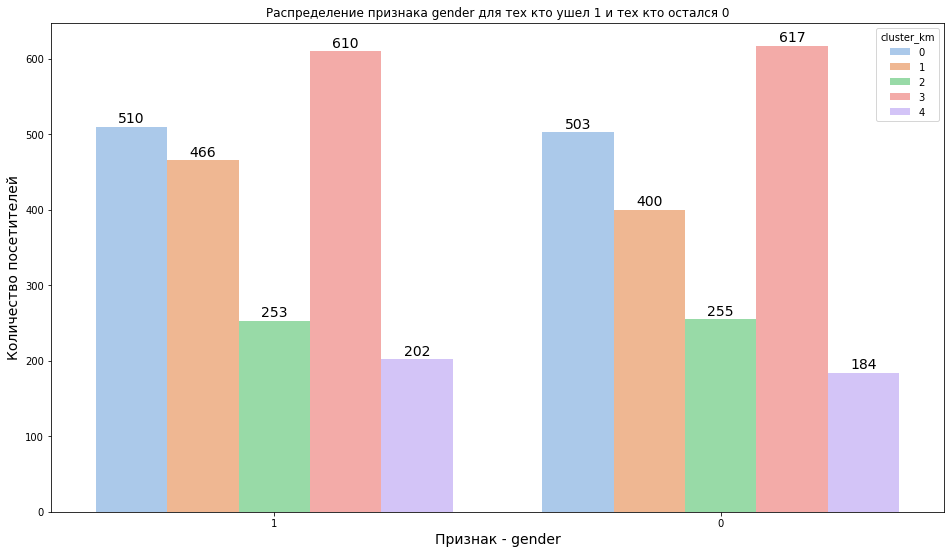

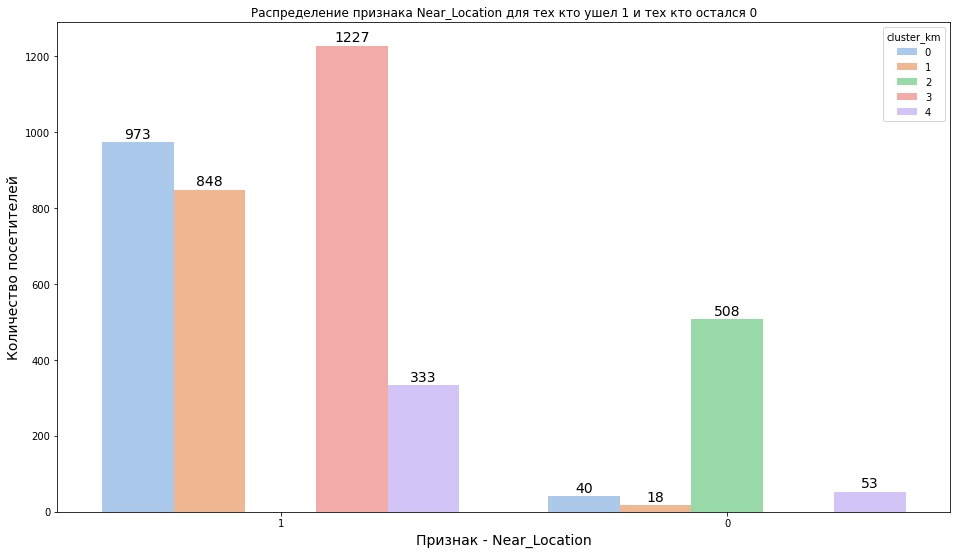

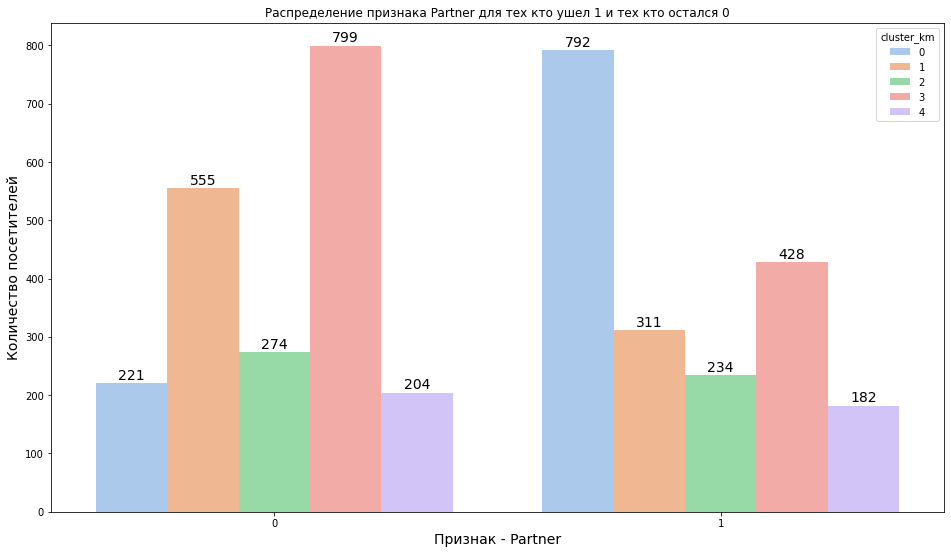

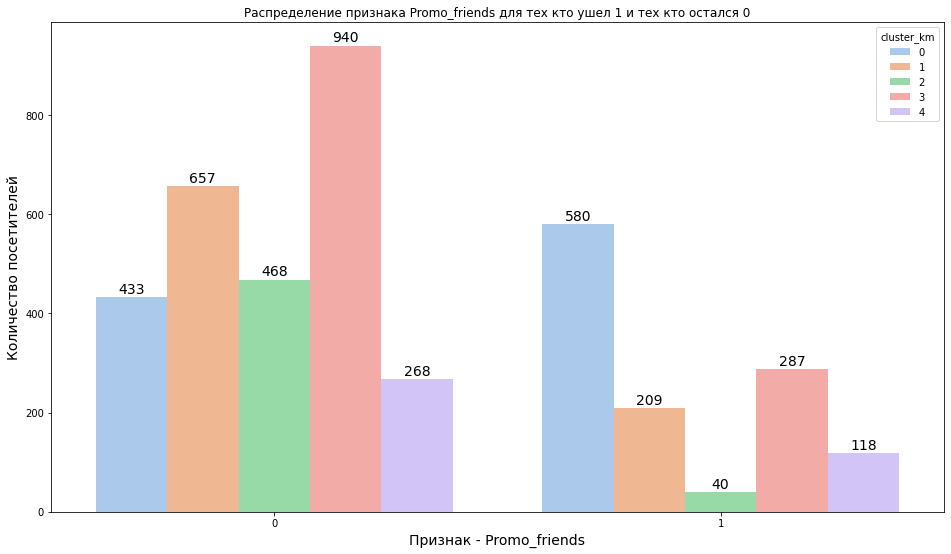

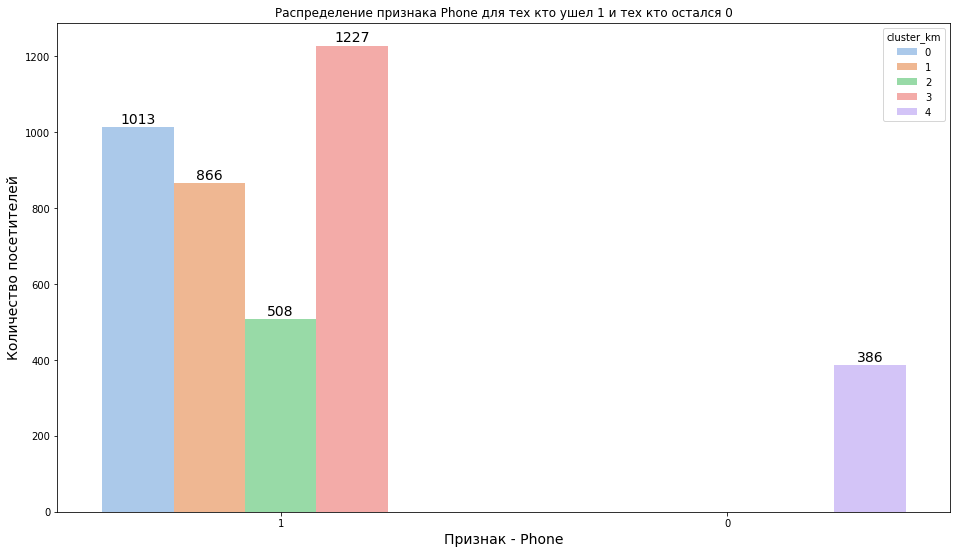

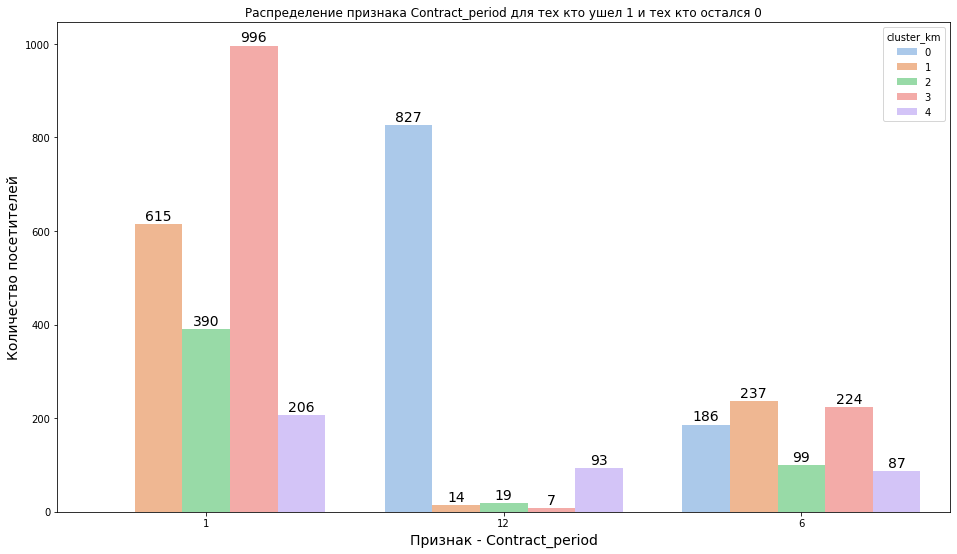

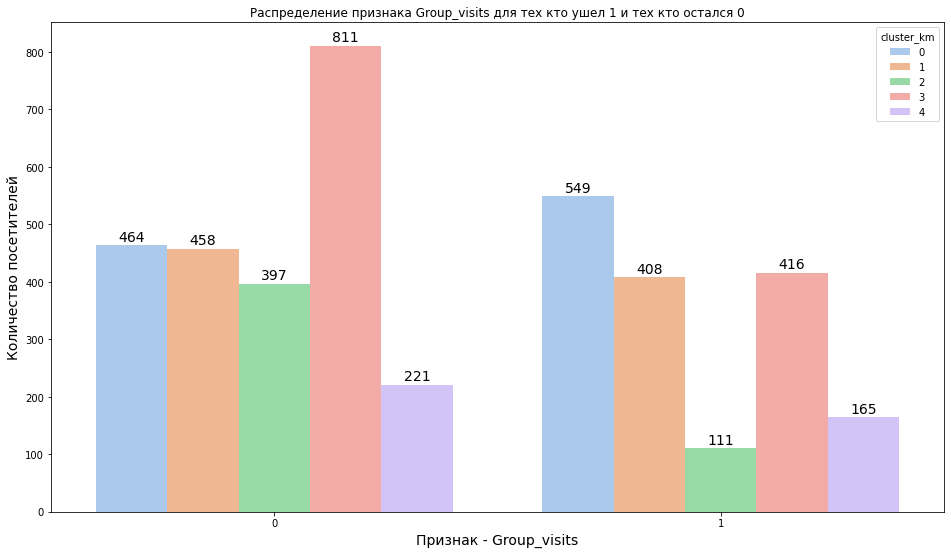

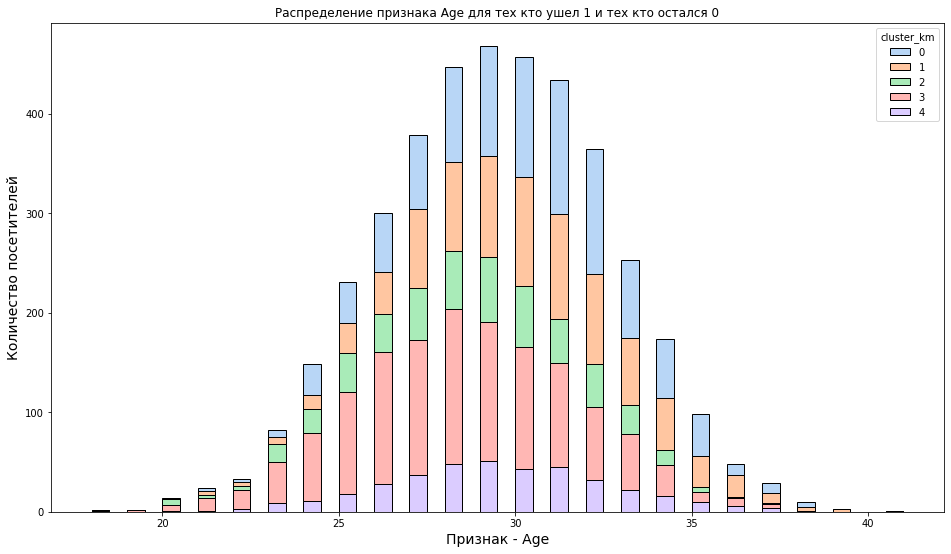

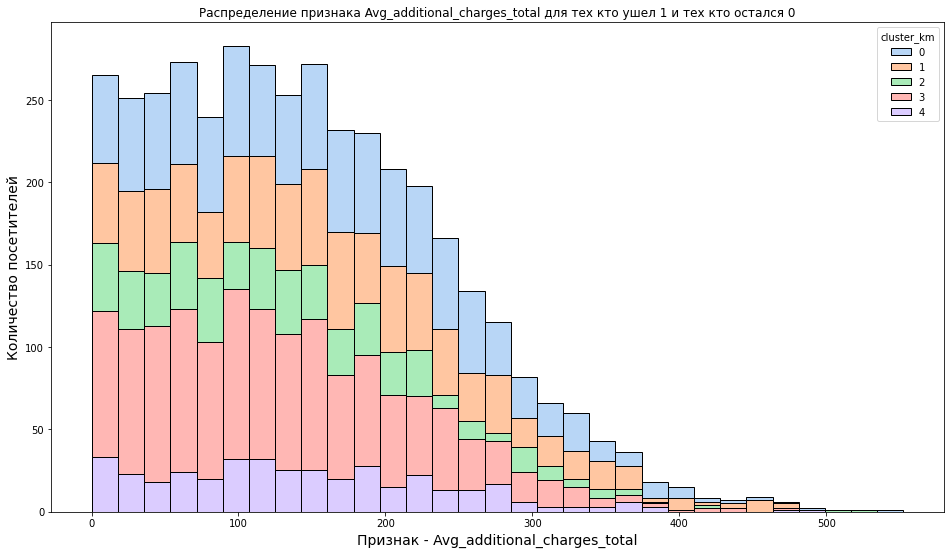

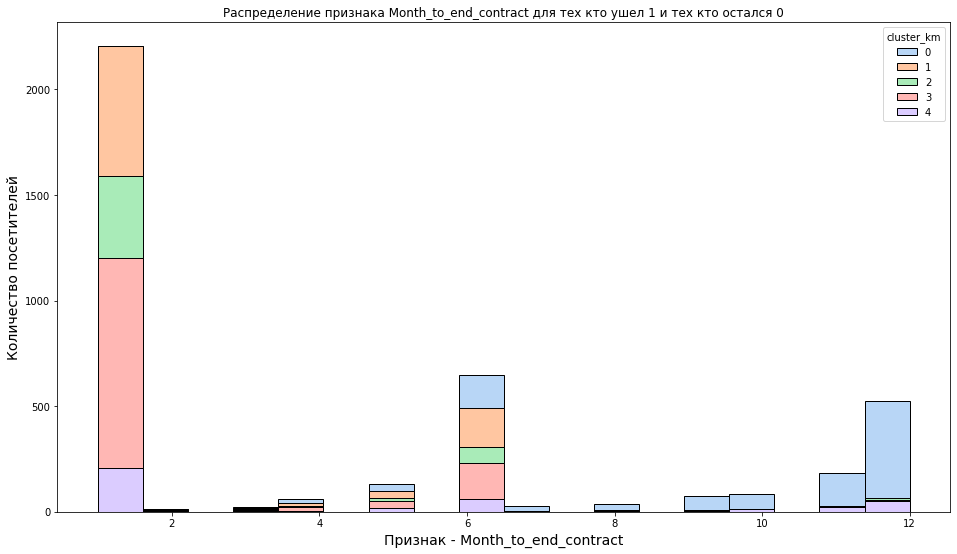

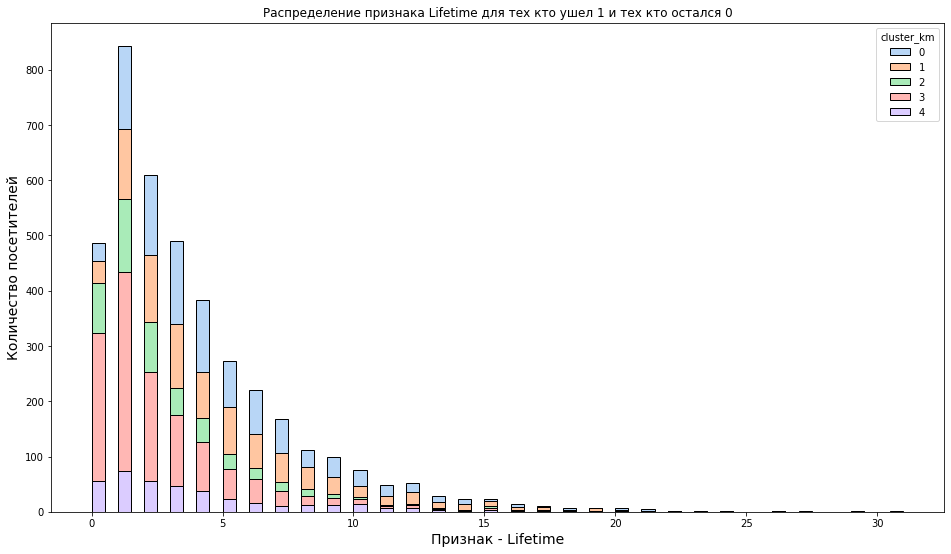

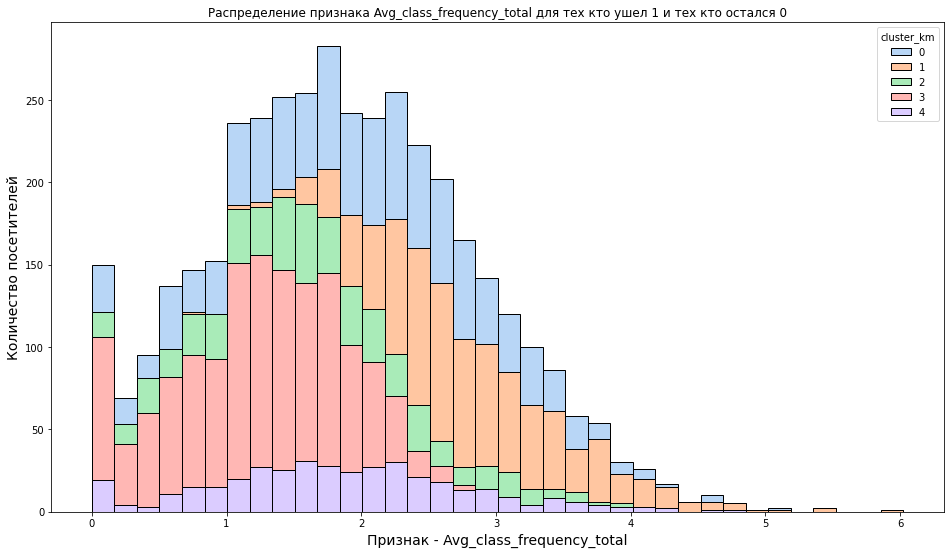

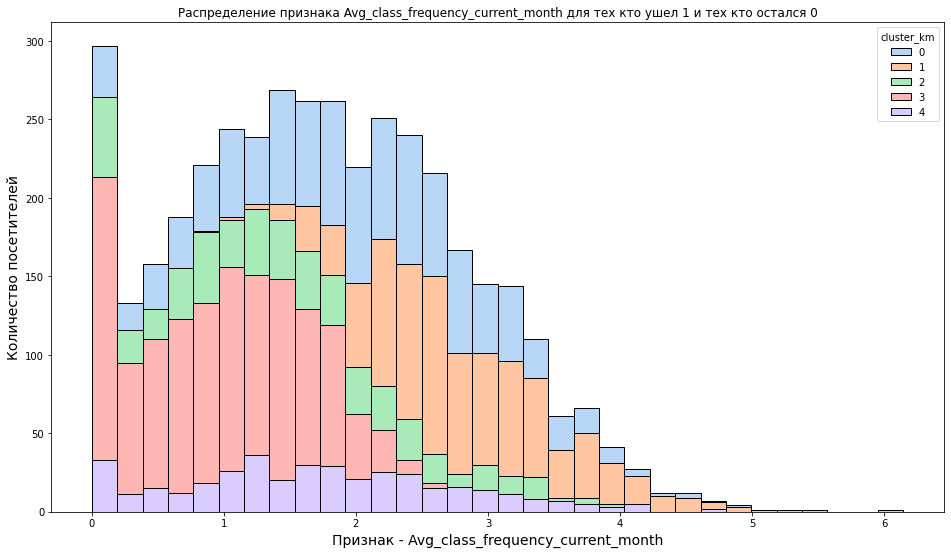

In [38]:
for i in gym_raw_data.drop(['cluster_km', 'Churn'], axis=1).columns:
    plt.figure(figsize=(16, 9)) 
    if i in categorical_var:
        ax = sns.countplot(data=gym_raw_data, x=i, hue='cluster_km', palette='pastel',
                      order=gym_raw_data[i].value_counts().index)
        for container in ax.containers:
            ax.bar_label(container, padding=1, fontsize=14)
    else:
        sns.histplot(data=gym_raw_data, x=i, hue='cluster_km', multiple="stack", palette='pastel')
    plt.title('Распределение признака {} для тех кто ушел 1 и тех кто остался 0'.format(i))
    plt.ylabel('Количество посетителей', fontsize=14)
    plt.xlabel('Признак - {}'.format(i), fontsize=14)
    plt.show()

###  График доли оттока по кластерам

In [39]:
churn_cluster_per = gym_raw_data.groupby(['cluster_km', 'Churn']).agg({'Churn' : 'count'}).rename(columns={"Churn": "client_cnt"}).reset_index()
client_in_clusters = gym_raw_data.groupby('cluster_km').agg({'Churn' : 'count'}).rename(columns={'Churn': 'All_client_cnt'}).reset_index()
churn_cluster_per = churn_cluster_per.merge(client_in_clusters, how='left', on='cluster_km' )
churn_cluster_per['All_client_cnt'] = (100 / churn_cluster_per['All_client_cnt'])* churn_cluster_per['client_cnt']
churn_cluster_per

cluster_km  Churn  client_cnt  All_client_cnt
0           0      0         985       97.235933
1           0      1          28        2.764067
2           1      0         805       92.956120
3           1      1          61        7.043880
4           2      0         284       55.905512
5           2      1         224       44.094488
6           3      0         582       47.432763
7           3      1         645       52.567237
8           4      0         283       73.316062
9           4      1         103       26.683938

In [40]:
churn_cluster_per['All_client_cnt'] = churn_cluster_per['All_client_cnt'].round(1)

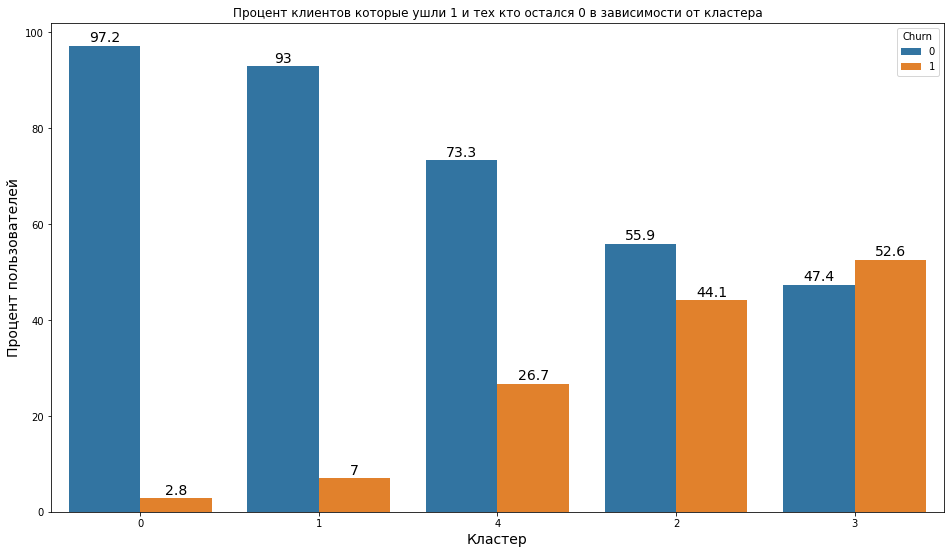

In [41]:
plt.figure(figsize=(16, 9)) 
ax = sns.barplot(x="cluster_km", y="All_client_cnt", data=churn_cluster_per, hue='Churn', hue_order=[0, 1], order=[0,1,4,2,3])
for container in ax.containers:
            ax.bar_label(container, padding=1, fontsize=14)
plt.title('Процент клиентов которые ушли 1 и тех кто остался 0 в зависимости от кластера')
plt.ylabel('Процент пользователей', fontsize=14)
plt.xlabel('Кластер', fontsize=14)
plt.show()

Меньше всего уходят люди из 0 и 1 кластера. Эти кластеры входят в 3 по количеству отнесенных к кластеру клиенов от общего числа. Кластер под номером 3 к которому относится существенная часть посетителей фитнес центра показывает отрицательную динамику. Клиенты этого класса с в половине сдучаев уходят.

### Вывод по кластеризации клиентов
На основании проведенного анализа и постороенной матрицы растояний было  принято разделить клиентов на 5 условных кластеров. Далее произведен анализ и сравнение признаков по каждому кластеру и сделаны следущие выводы:
 - Киленты по признаку `gender` распределены в каждом кластере равномерно примерно в каждом калстере поровну и мужчин и женщин
 - Клиенты фитнес-центра которые попали во 2 кластер в основном не живут и не работают в том районе где расположен фитнес-центр. Клиенты других кластеров в основном имеют отношения к этому району.
 - По признаку `partner` клиенты 2  и 4 кластера поделились по ровну.  Примерно 70% клиентов из 0 кластера занимаются по партнерской программе а вот клиенты 1 и 3 наоборот примерно 60% из этих кластеров не участвуют в партнерской программе
 - По признаку `Promo_friends` почти в каждом кластере привалирует количество людей которые не участвовали в программе приведи друга крогме кластера 0 там таких клиентов больше.
 - По признаку `Phone` выделяется кластер 4. У фитнес-центра нет информации о номерах телефонов клиентов этого клатсера. По всем клиентам других кластеров эта информация имеется
 - По длительности текущего действующего абонемента `Contract_period` можно выделить клиентов 0 кластера. У них в основном действует абогиметн еще 12 месяцев или 6. Клиентам других кластеров в основном остался 1 месяц до окончаня действия абонимента. Кластер 4 выглядит более равномерно по этому признаку.
 - По групповым визитам можно выделить кластер 0. Там клиенты в большей  степени склонны посещать групповые занятия. По другим группам картина противоположная.
 - Средний возраст клиентов по класетрам:
    * 0 - 29
    * 1 - 30
    * 2 - 28.5
    * 3 - 28
    * 4 - 29
   
   Хоть разница в между кластерами по возрасту не сильно большая можно заметить что от 0го кластера к 4 распределение среди клиентов в кластере становится более равноменрым и все сложнее выделять определенную возрастную категорию
  
- Распределение по суммарной выручки среди всех кластеров имеет одниаковую форму. В среднем больше всего тратят на доп услуги клиенты первого и второго кластера а меньше всего третьего.
- По признаку лайфтайм рапределение среди кластеров выглядит одинаково. В среднем клиенты 0 и 1 кластера обращались первый раз в фитнес центр примерно 5 месяце назад, клиенты 2 кластера примерно 3 месяца назад, 3-го - 2.5 а 4-го - почти 4 месяца назад.
- По признакам среднего посещения в неделю за все время `Avg_class_frequency_total` и среднея частота посещений за предыдущий месяц `Avg_class_frequency_current_month` можно выделить клиентов кластера 1. Они больше всех в среднем посещают фитнес-центр почти по 3 раза в неделю. Клиенты кластера 0 посещают в среднем 2 раза в неделю. Клиенты кластера 2  1-2 раза в неделю посещают фитнес центр. Меньше всего посещений у клиентов  кластера 3 1 занятие в неделю. Клиенты кластера 4 распределены более равномерно по количеству посещений а в среднем человек этого кластера посещает фитнес-центр 2 раза в неделю.

Среди всех кластеров процент оттока меньше всего у клиентов 0 кластера - 2.8 процентов. Больше всего доля оттока клиентов зафиксирована у клиентов кластера 3 (больше половины ушли в текущем месяце)

На основе анализа каждого из признаков можно сделать портрет клиента каждого кластера:

* Кластер 0 - Клиент в районе 29-30 лет проживающий или работающий в раоне расположения фитнес-центра. Данный клиент в основном принимал участие или в партнерской программе или в программе `Приведи друга` так же с большой вероятностью принимающий участи в групповых занятиях. В основном абонимент у данного клиента еще расчитан на ближайший год посещения фитнес-центра. В среднем посещает 2 раза в неделю а суммарная выручка от других услуг центра выше одна из самых высоких среди других кластеров - 160 Клиенты первый раз обращались примерно 5 месяцев назад
* Кластер 1 - Клиентаы по многим критериям очень похожи на клиентов кластера 0. Так же возраст в районе 30 лет бизкая доступность к фитнес-центру. В основном клиенты не участвовали в клиентской программе и еще меньше в акции приведи руга. Так же активно посещают групповые занятия. В основном абонемент у клиентав данного класса был оформлен или на 1 или 6 месяцев. Так же клиенты данного класса активно пользуются дополнительными услугами фитнес-центра. Количество посещений клиентов  самое высокое среди других кластеров - в среднем по 3 занятия в неделю. Клиенты первый раз обращались примерно 5 месяцев назад
* Кластер 2 это клиенты в районе 28 лет проживающие или работающие в другом районе относительно фитнес центра. Примерно половина клиентов данного группы участвовала в партнерской программе. В основном действующий абонемент рассчитан на 1 и 6 месяцкв. Примерно четверть из них участвуетв в групповых занятиях. В среднем эти клиенты ходят по 1-2 раза в неделю. Суммарная выручка от других услуг по эти клиентам средняя среди всех кластеров. Очень большой процент оттока скорее всего связан по причине улаленности фитнес-центра от места жительста или работы клиента. Клиенты первый раз обращались примерно 3  месяцев назад
* Кластер 3  клиенты проживающие только в районе фитнес-центра. Треть от общего чила этих клиенто участвует в партнерской программе  и акции приведи друга. Дейстующий абонемент еще расчитан на 1 месяц или 6. Клиенты данного кластера имеют самую низкую посешаемость в неделю (в среднем 1 занятие) и не охотно пользуются дополнительными услугами фитнес центра. треть клиентов участвовали в групповых занятих. Процент оттока среди всех групп самый большой
* Кластер 4 - Клиенты в среднем в возрасте 29 лет в основном проживающие в месте где находится фитнес-центр. Примерно половина этих клиентов участвовала в партнерской программе и примерно треть в акции приведи друга. Отличитеьлной особенностью клиентов данного кластера заключается в отсутствии номера телефона в базе по этим клиентам. Примерно половина клиентов участвовала в групповых занятиях а в среднем они посещают фитнес-центр 2 раза в неделю. Клиенты данного кластера имеют действующий абонемент на 1 6 и 12 месяцев примерно в равных долях. Первое обращение данных клиентов в фитнес центр было примерно 4 месяца назад. На дополнительные услуги клиенты данного кластера таратять выше среднего относительно других. Процент оттока по ним чуть больше четверти.

## Итоговый Вывод 

Основные выводы по анализу оттока клиентов:
Среди клиентов выделяется следущие  категории:
* Клиенты которым в среднем в районе 30 лет которые имеют деюствующий абоенмент на ближайшие 6-12 месяцев которые проживает или работаю  в районе фитнес-центра так же активно участвуют в партнерской программе а их количество псещений в месяц варьируется от 2-3 посещенти. Отток таких клиентов от 3 до 7 процентов
* Клиенты в возрасте 28  в среднем которые проживают в районе расположения фитнес-центра но у которых действующий абонемент расчитан от 1 до 6 месяцев. Менший процент этих клиентов принимал участие в партнерской программе и групповых занятих относительно предедущей категории и в среднем эти клиенты ходят 1 раз в неделю 
* В 3 категорию клиентов попадают люди с другого района. В среднем посещают фитнес-центр в районе 1-2 раз в неделю. Очень большеой процент оттока среди таких клиентов скорее всего связан с удаленность фитнес центра


Рекомендации для стратегии взаимодействия с клиентами для их удержания:
* Клиенты которые недавно взяли абонименты на небольшой срак до 6 месяцев. Для таких клиентов можно сформировать ряд предложений таких как (бесплатное занятие с тренером или более активное привлечение к групповым занятием) 
* Клиентам проживающим в другом районе относительно данного фитнес-центра проработать возможность получить абонимент на особых условиях (посщения любого фитнес-центра сети  или вариант где выделен определенный временной интервал для посещений тем самым уменьшится стоимость абонимента)
* Возможно проработать определенные групповые занятия для людей моложе 26 так как удержание клиентов данной категории один из самых низких